# 1. Introuction

 This notebook outlines the creation, compilation, and training of multiple ViT networks to classify 101 types of food. Both PyTorch's default ViT models and custom ViT models will be used for this task. While no transfer learning will be applied, PyTorch's pretrained weights will be used to initialize the models. To ensure a fair comparison, all models will be trained using the same number of epochs, learning rate, and regularization settings. These parameters have been determined based on prior experimentation.

The following table summarize the models:

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Hidder Layer Units for Classification** | **Transfer Learning** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 64 | DEFAULT | 60 | 0.0001 | CosineAnnealingLR | 85.9M |
| 2 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |
| 3 | PyTorch's Default Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 64 | DEFAULT | 60 | 0.0001 | CosineAnnealingLR | 85.9M |
| 4 | PyTorch's Default Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

The custom vision transformer architectures have been implemented from scratch based on the paper titled ["An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale"](https://arxiv.org/abs/2010.11929). The custom library is called **vision_transformer** where the **ViT class** can be imported.

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets

# Import custom libraries
from modules.helper_functions import create_dataloaders, set_seeds, display_random_images, save_model, load_model
from modules.engine import Trainer
from modules.vision_transformer import ViT, ViTv2, create_vit
#from modules.scheduler import WarmupCosineAnnealingLR
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler


# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Tue Dec 31 17:17:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   51C    P8             12W /  200W |    1712MiB /  12282MiB |      7%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Dataloaders and Image Visualization

In [3]:
# Image size
IMG_SIZE = 224
IMG_SIZE_2 = 384

def data_loaders(
        vit_model: str="bitbase16",
        train_dir: str=TRAIN_DIR,
        test_dir: str=TEST_DIR,
        batch_size: int=64,
        aug: bool=True,
        display_imgs: bool=True):
    
    """
    Creates data loaders for the training and test datasets.

    Args:
        vit_model (str): The name of the ViT model to use. Default is "bitbase16".
        train_dir (str): The path to the training dataset directory. Default is TRAIN_DIR.
        test_dir (str): The path to the test dataset directory. Default is TEST_DIR.
        batch_size (int): The batch size for the data loaders. Default is BATCH_SIZE.
        aug (bool): Whether to apply data augmentation or not. Default is True.
        display_imgs (bool): Whether to display sample images or not. Default is True.

    Returns:
        train_dataloader (torch.utils.data.DataLoader): The data loader for the training dataset.
        test_dataloader (torch.utils.data.DataLoader): The data loader for the test dataset.
        class_names (list): A list of class names.
    """

    # Manual transforms for the training dataset
    manual_transforms = v2.Compose([           
        v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),    
    ])

    # ViT-Base/16 transforms
    if vit_model == "vitbase16":

        # Manual transforms for the training dataset
        if aug:
            manual_transforms_train_vitb = v2.Compose([    
                v2.TrivialAugmentWide(),
                v2.Resize((256, 256)),
                v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) 
            ])
        else:
            manual_transforms_train_vitb = v2.Compose([
                v2.Resize((256, 256)),
                v2.CenterCrop((IMG_SIZE, IMG_SIZE)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

        # Manual transforms for the test dataset
        manual_transforms_test_vitb = v2.Compose([    
            v2.Resize((256, 256)),
            v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]) 
        ])

        # Create data loaders for ViT-Base
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=train_dir,
            test_dir=test_dir,
            train_transform=manual_transforms_train_vitb,
            test_transform=manual_transforms_test_vitb,
            batch_size=batch_size,
            num_workers=NUM_WORKERS
            )
    
    if vit_model == "vitbase16_2":

        # Manual transforms for the training dataset
        if aug:
            manual_transforms_train_vitb = v2.Compose([    
                v2.TrivialAugmentWide(),
                v2.Resize((IMG_SIZE_2, IMG_SIZE_2)),
                v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),    
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) 
            ])
        else:
            manual_transforms_train_vitb = v2.Compose([
                v2.Resize((IMG_SIZE_2, IMG_SIZE_2)),
                v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

        # Manual transforms for the test dataset
        manual_transforms_test_vitb = v2.Compose([    
            v2.Resize((IMG_SIZE_2, IMG_SIZE_2)),
            v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]) 
        ])

        # Create data loaders for ViT-Base
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=train_dir,
            test_dir=test_dir,
            train_transform=manual_transforms_train_vitb,
            test_transform=manual_transforms_test_vitb,
            batch_size=batch_size,
            num_workers=NUM_WORKERS
            )

    # ViT-Large/16 transforms
    elif vit_model == "vitlarge16":

        # Manual transforms for the training dataset
        if aug:
            manual_transforms_train_vitl = v2.Compose([    
                v2.TrivialAugmentWide(),
                v2.Resize((242, 242)),
                v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) 
            ])
        else:
            manual_transforms_train_vitl = v2.Compose([
                v2.Resize((242, 242)),
                v2.CenterCrop((IMG_SIZE, IMG_SIZE)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

        # Manual transforms for the test dataset
        manual_transforms_test_vitl = v2.Compose([    
            v2.Resize((242, 242)),
            v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]) 
        ])

        # Create data loaders for ViT-Large/16
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=train_dir,
            test_dir=test_dir,
            train_transform=manual_transforms_train_vitl,
            test_transform=manual_transforms_test_vitl,
            batch_size=batch_size
        )

    # ViT-Large/32 transforms
    else:
        # Manual transforms for the training dataset
        if aug:
            manual_transforms_train_vitl = v2.Compose([    
                v2.TrivialAugmentWide(),
                v2.Resize((256, 256)),
                v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]) 
            ])
        else:
            manual_transforms_train_vitl = v2.Compose([
                v2.Resize((256, 256)),
                v2.CenterCrop((IMG_SIZE, IMG_SIZE)),
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
            ])

        # Manual transforms for the test dataset
        manual_transforms_test_vitl = v2.Compose([    
            v2.Resize((256, 256)),
            v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225]) 
        ])

        # Create data loaders for ViT-Large/32
        train_dataloader, test_dataloader, class_names = create_dataloaders(
            train_dir=train_dir,
            test_dir=test_dir,
            train_transform=manual_transforms_train_vitl,
            test_transform=manual_transforms_test_vitl,
            batch_size=batch_size
        )

    # Display images
    if display_imgs:
        train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
        display_random_images(train_data,
                        n=25,
                        classes=class_names,
                        rows=5,
                        cols=5,
                        display_shape=False,
                        seed=None)
    
    return train_dataloader, test_dataloader, class_names

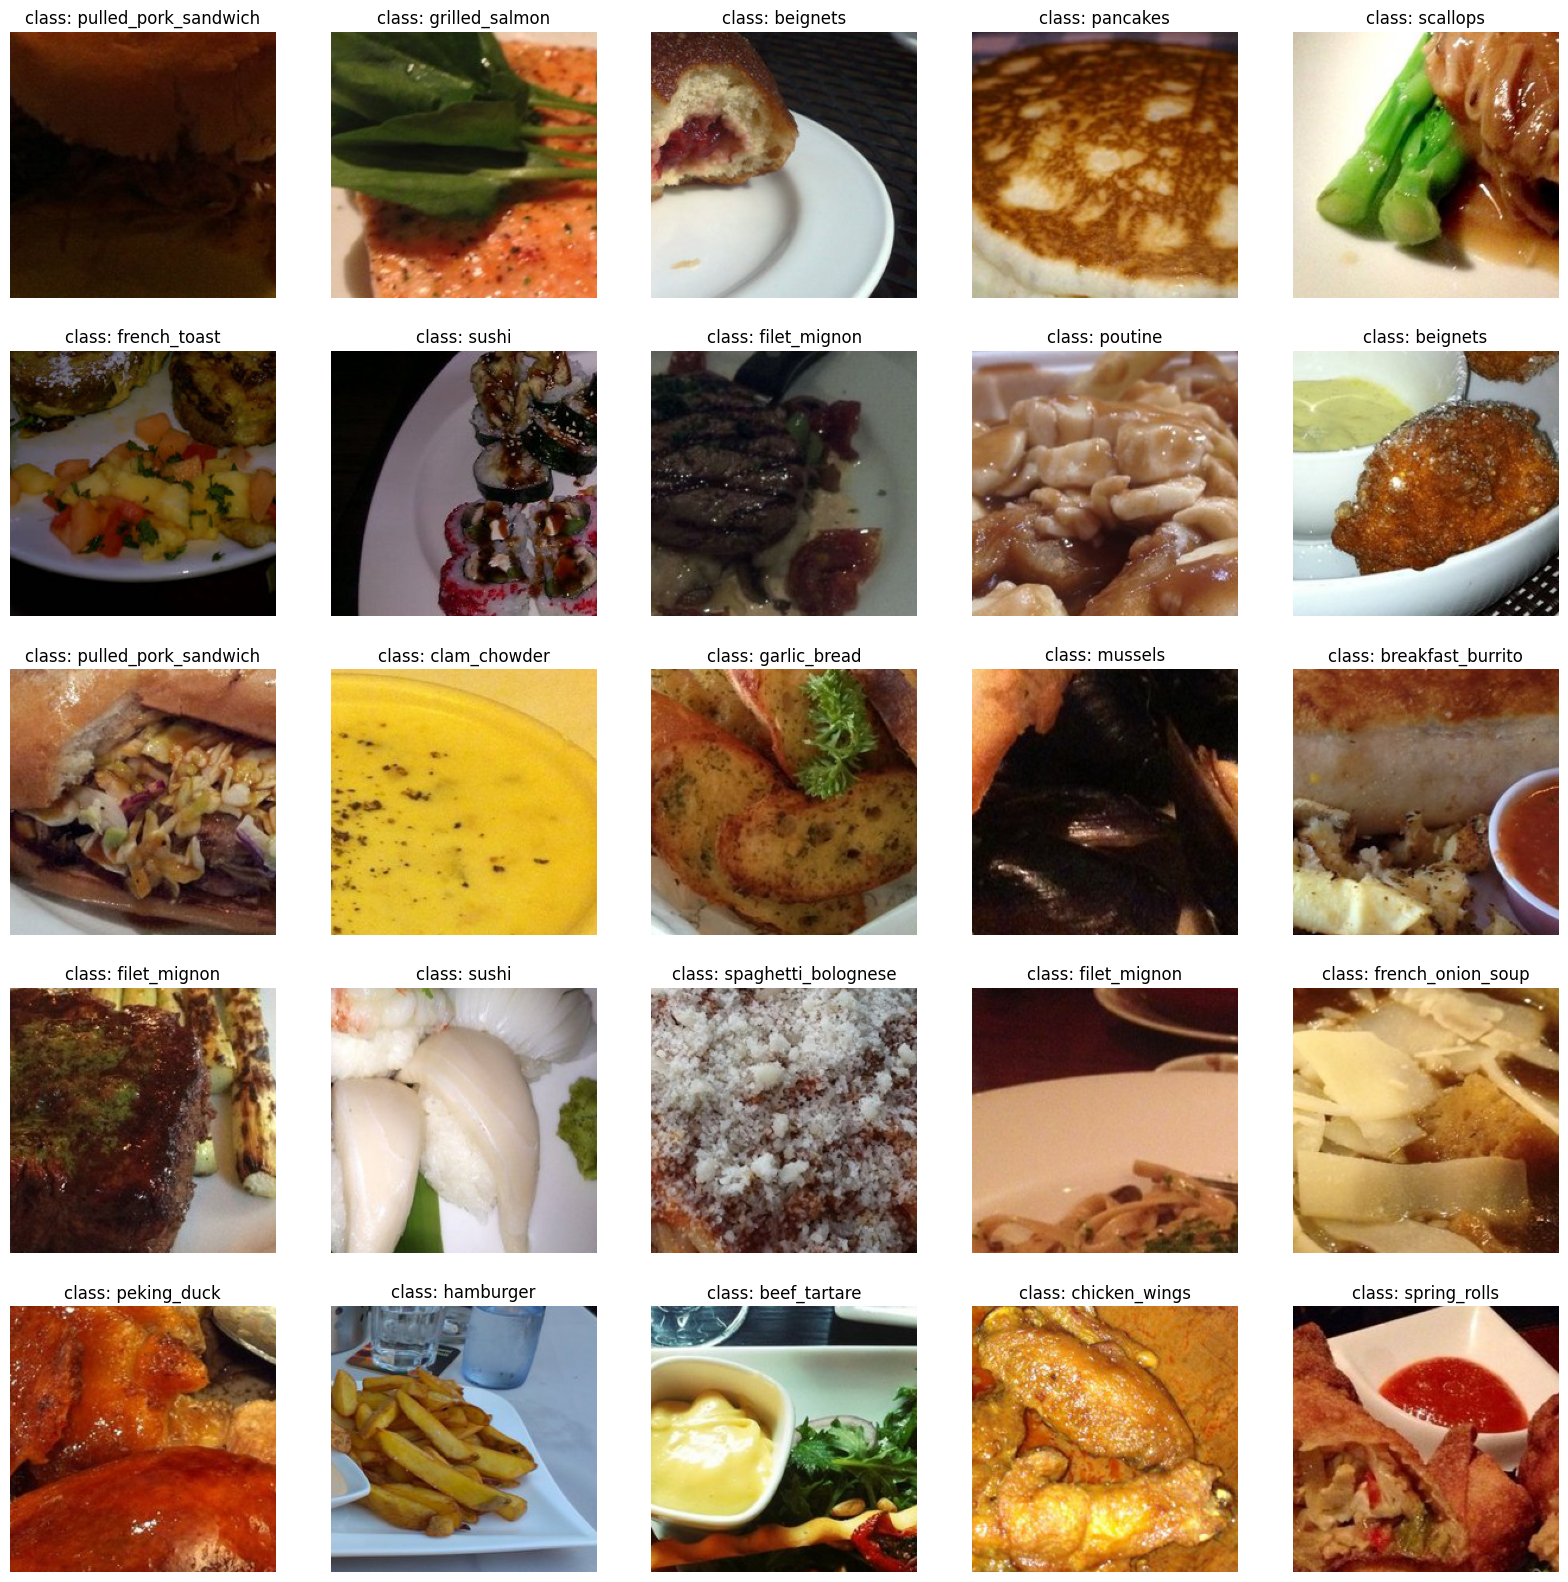

In [4]:
# Display images
_, _, _ = data_loaders(display_imgs=True)

# 5. Training

## 5.1. Custom ViT-Base/16 - Weights: DEFAULT

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 1 | Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 64 | DEFAULT | 60 | 0.0001 | CosineAnnealingLR | 85.9M |

In [7]:
# Create dataloaders
BATCH_SIZE = 64
train_dataloader_vitb, test_dataloader_vitb, class_names = data_loaders(
    vit_model="vitbase16",
    batch_size=BATCH_SIZE,
    aug=True,
    display_imgs=False
    )

# Create the ViT-Base model
vitbase16_1_model = ViT(
    img_size=IMG_SIZE,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

# Copy weights from torchvision.models.ViT_B_16_Weights.DEFAULT (note: except the header to be trained)
vitbase16_1_model.copy_weights(torchvision.models.ViT_B_16_Weights.DEFAULT)

# And freeze the backbone except the classification head params
#vitbase16_model.set_params_frozen(except_head=True)

# Compile model
vitbase16_1_model = torch.compile(vitbase16_1_model, backend="aot_eager")

# Print summary
summary(vitbase16_1_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Model weights copied successfully.
[INFO] Model weights are trainable by default. Use function set_params_frozen to freeze them.


c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [64, 3, 224, 224]    [64, 101]            --                   True
├─ViT (_orig_mod)                                                 [64, 3, 224, 224]    [64, 101]            --                   True
│    └─PatchEmbedding (embedder)                                  [64, 3, 224, 224]    [64, 197, 768]       152,064              True
│    │    └─Conv2d (conv_proj)                                    [64, 3, 224, 224]    [64, 768, 14, 14]    590,592              True
│    │    └─Flatten (flatten)                                     [64, 768, 14, 14]    [64, 768, 196]       --                   --
│    │    └─Dropout (emb_dropout)                                 [64, 197, 768]       [64, 197, 768]       --                   --
│    └─Sequential (encoder)                                  

Epoch: 10 | train_loss: 1.0280 | train_acc: 0.9328 | fpr_at_recall: 0.0015 | train_time: 6m13s | test_loss: 1.1897 | test_acc: 0.8770 | fpr_at_recall: 0.0082 | test_time: 1m32s | lr: 0.0000034227


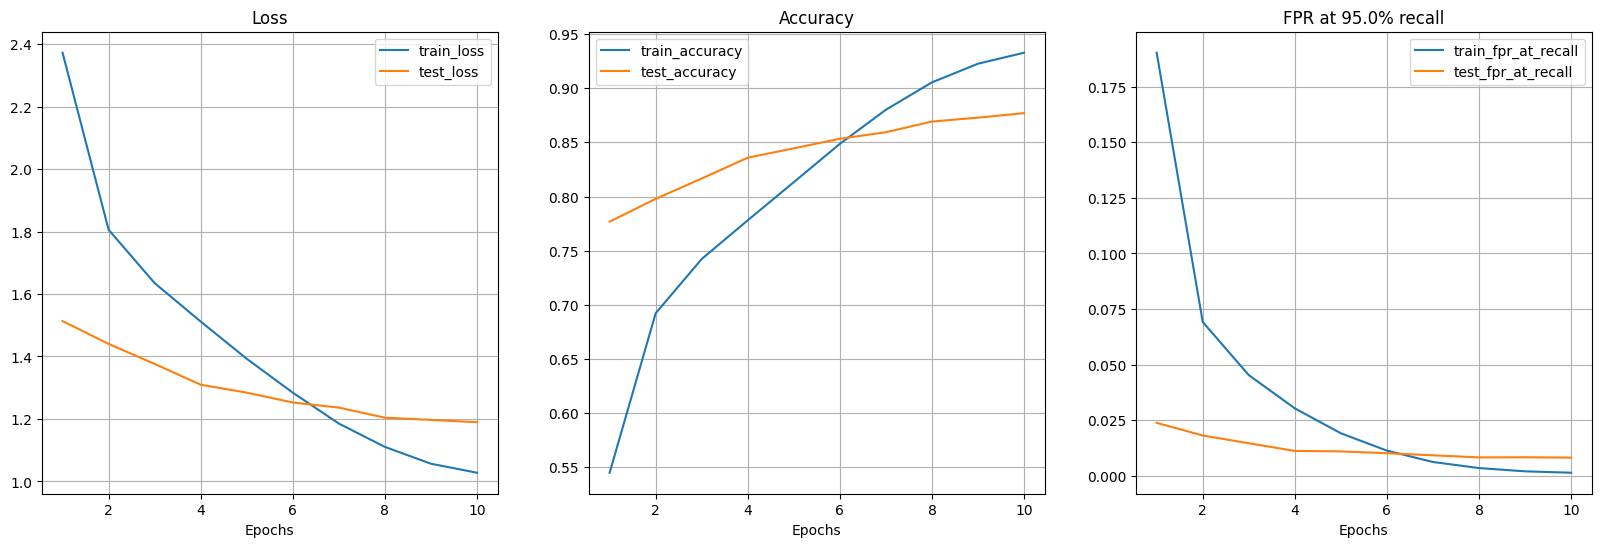

[INFO] Saving model to: ..\models\vitbase16_1_best.pth
[INFO] Saving model to: ..\models\vitbase16_1.pth


In [8]:
# Train the model
model_type="vitbase16_1"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
vitbase16_1_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_1_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=vitbase16_1_model,
    save_best_model=True,
    mode="max", # Based on accuracy
    device=device)

vitbase16_1_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=vitbase16_1_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=1,
    )

## 5.2. Custom ViT-Base/16 - Weights: IMAGENET1K_SWAG_E2E_V1

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 2 | Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

In [7]:
# Create dataloaders
BATCH_SIZE = 32
train_dataloader_vitb, test_dataloader_vitb, class_names = data_loaders(
    vit_model="vitbase16_2",
    batch_size=BATCH_SIZE,
    aug=True,
    display_imgs=False
    )

# Create the ViT-Base model
vitbase16_2_model = ViT(
    img_size=IMG_SIZE_2,
    in_channels=3,
    patch_size=16,
    num_transformer_layers=12,
    emb_dim=768,
    mlp_size=3072,
    num_heads=12,
    attn_dropout=0,
    mlp_dropout=0.1,
    emb_dropout=0.1,
    num_classes=len(class_names)
)

# Copy weights from torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1 (note: except the header to be trained)
vitbase16_2_model.copy_weights(torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)

# And freeze the backbone except the classification head params
#vitbase16_model.set_params_frozen(except_head=True)

# Compile model
vitbase16_2_model = torch.compile(vitbase16_2_model, backend="aot_eager")

# Print summary
summary(vitbase16_2_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE_2, IMG_SIZE_2), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Model weights copied successfully.
[INFO] Model weights are trainable by default. Use function set_params_frozen to freeze them.


c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [32, 3, 384, 384]    [32, 101]            --                   True
├─ViT (_orig_mod)                                                 [32, 3, 384, 384]    [32, 101]            --                   True
│    └─PatchEmbedding (embedder)                                  [32, 3, 384, 384]    [32, 577, 768]       443,904              True
│    │    └─Conv2d (conv_proj)                                    [32, 3, 384, 384]    [32, 768, 24, 24]    590,592              True
│    │    └─Flatten (flatten)                                     [32, 768, 24, 24]    [32, 768, 576]       --                   --
│    │    └─Dropout (emb_dropout)                                 [32, 577, 768]       [32, 577, 768]       --                   --
│    └─Sequential (encoder)                                  

Epoch: 10 | train_loss: 0.9198 | train_acc: 0.9688 | fpr_at_recall: 0.0002 | train_time: 16m21s | test_loss: 1.0734 | test_acc: 0.9161 | fpr_at_recall: 0.0030 | test_time: 2m54s | lr: 0.0000034227


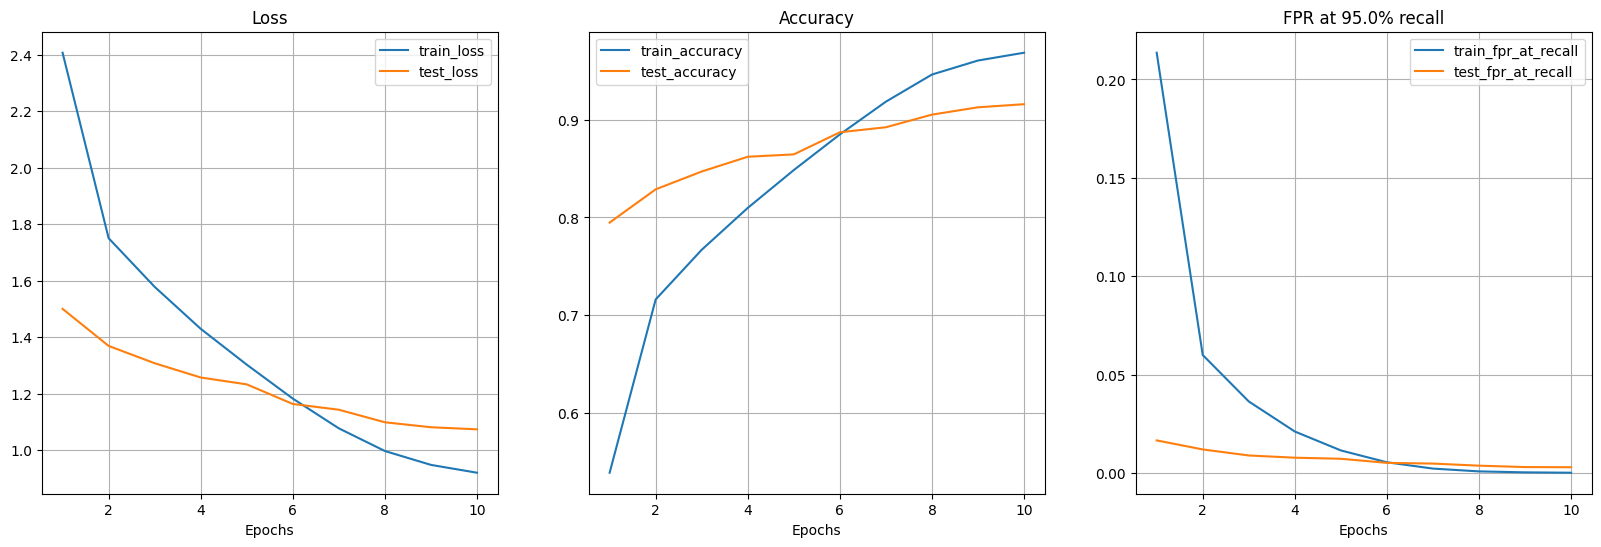

[INFO] Saving model to: ..\models\vitbase16_2_best.pth
[INFO] Saving model to: ..\models\vitbase16_2.pth


In [ ]:
# Train the model
model_type="vitbase16_2" #_2024-12-31
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
vitbase16_2_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_2_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=vitbase16_2_model,
    save_best_model=True,
    mode="max", # Based on accuracy
    device=device)

vitbase16_2_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=vitbase16_2_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2,
    )

## 5.3. PyTorch's Default ViT-Base/16 - Weights: DEFAULT

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 3 | PyTorch's Default Base | 224x224 | 16x16 | 12 | 768 | 3072 | 12 | 64 | DEFAULT | 60 | 0.0001 | CosineAnnealingLR | 85.9M |

In [9]:
# Create dataloaders
BATCH_SIZE = 64
train_dataloader_vitb, test_dataloader_vitb, class_names = data_loaders(
    vit_model="vitbase16",
    batch_size=BATCH_SIZE,
    aug=True,
    display_imgs=False
    )

# Instatiate the model
vitbase16_3_model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT).to(device)
for parameter in vitbase16_3_model.parameters():
    parameter.requires_grad = True
set_seeds(SEED)
vitbase16_3_model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Compile model
vitbase16_3_model = torch.compile(vitbase16_3_model, backend="aot_eager")

Epoch: 10 | train_loss: 0.9323 | train_acc: 0.9617 | fpr_at_recall: 0.0003 | train_time: 5m54s | test_loss: 1.1565 | test_acc: 0.8856 | fpr_at_recall: 0.0067 | test_time: 1m27s | lr: 0.0000034227


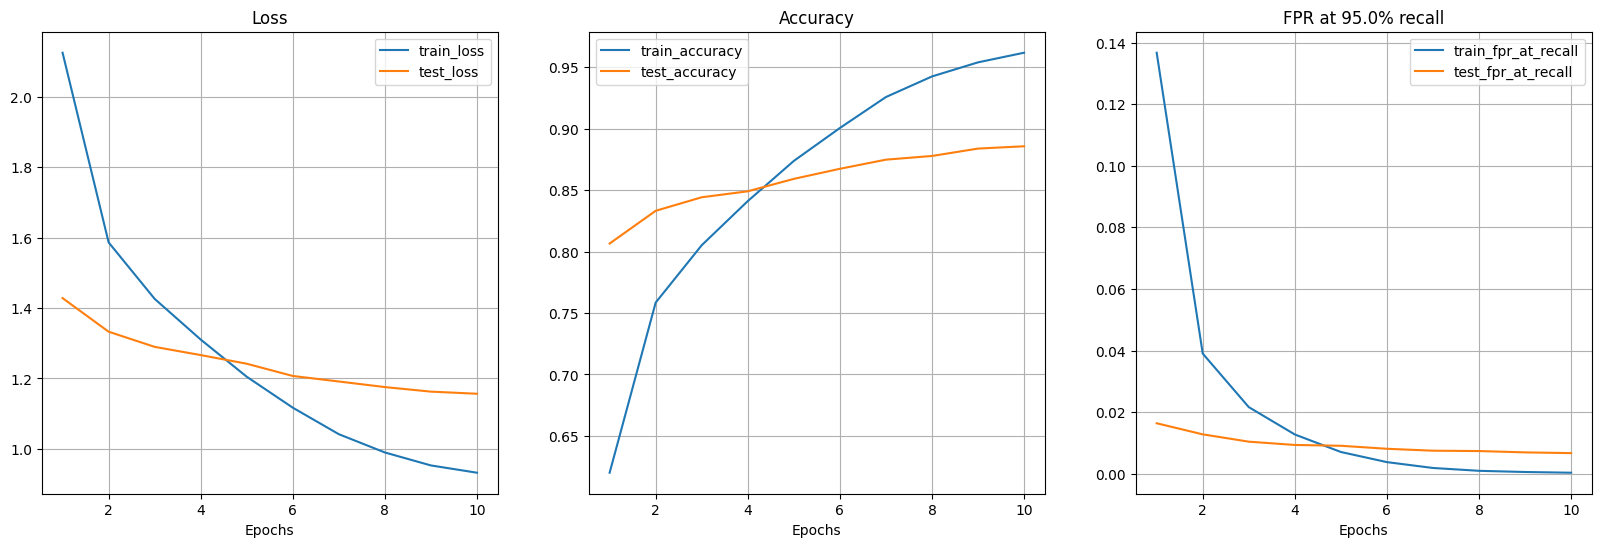

[INFO] Saving model to: ..\models\vitbase16_3_best.pth
[INFO] Saving model to: ..\models\vitbase16_3.pth


In [10]:
# Train the model
model_type="vitbase16_3"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
vitbase16_3_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_3_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=vitbase16_3_model,
    save_best_model=True,
    mode="max", # Based on accuracy
    device=device)

vitbase16_3_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=vitbase16_3_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=1,
    )

## 5.4. PyTorch's Default ViT-Base/16 - Weights: IMAGENET1K_SWAG_E2E_V1

| Version | **ViT Type** | **Image Size** | **Patch Size** | **Encoding Layers** | **Hidden Size** | **Multi-layer Perceptron size** | **Attention Heads** | **Batch Size** | **Model Weights (Initialization)** | **Number of Epochs** | **Learning Rate** | **Scheduler** | **Params**
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
| 4 | PyTorch's Default Base | 384x384 | 16x16 | 12 | 768 | 3072 | 12 | 64 | IMAGENET1K_SWAG_E2E_V1 | 60 | 0.0001 | CosineAnnealingLR | 86.2M |

In [ ]:
# Create dataloaders
BATCH_SIZE = 32
train_dataloader_vitb, test_dataloader_vitb, class_names = data_loaders(
    vit_model="vitbase16_2",
    batch_size=BATCH_SIZE,
    aug=True,
    display_imgs=False
    )

# Create ViT
vitbase16_4_model = create_vit(vit_model="vitbase16_2", num_classes=len(class_names), seed=SEED, device=device)

# Compile model
vitbase16_4_model = torch.compile(vitbase16_4_model, backend="aot_eager")

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


Epoch: 10 | train_loss: 0.9577 | train_acc: 0.9598 | fpr_at_recall: 0.0004 | train_time: 16m15s | test_loss: 1.1049 | test_acc: 0.9063 | fpr_at_recall: 0.0041 | test_time: 2m47s | lr: 0.0000034227


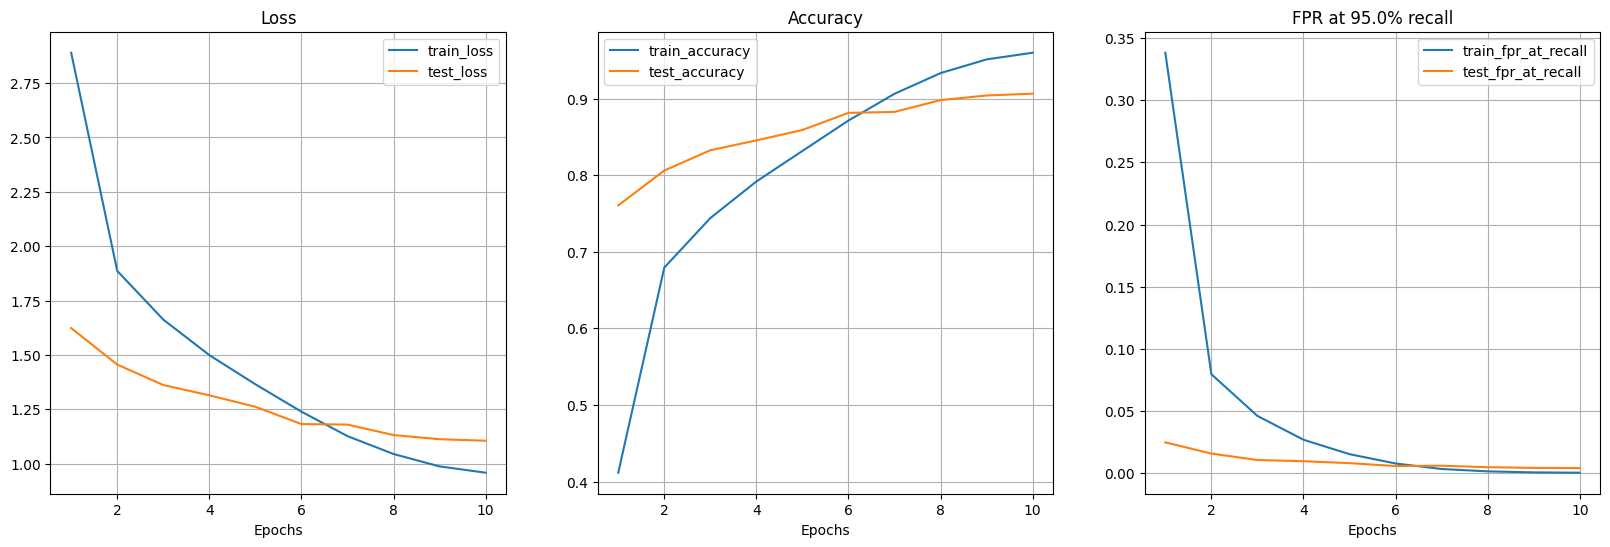

[INFO] Saving model to: ..\models\vitbase16_4_best.pth
[INFO] Saving model to: ..\models\vitbase16_4.pth


In [8]:
# Train the model
model_type="vitbase16_4"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
vitbase16_4_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=vitbase16_4_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=vitbase16_4_model,
    save_best_model=True,
    mode="max", # Based on accuracy
    device=device)

vitbase16_2_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=vitbase16_4_model_name,
    train_dataloader=train_dataloader_vitb,
    test_dataloader=test_dataloader_vitb,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=2,
    )